<a href="https://colab.research.google.com/github/sanduerhan/Licenta/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

In [1]:
#importing the dataset
import pandas as pd
import nltk
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
from nltk.corpus import stopwords, words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import gensim
import re, string
from string import punctuation, digits
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.initializers import Constant
from keras import layers
from keras.layers import ReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
import keras.backend as K

col_list = ["Column2", "Column3"]
dataset = pd.read_excel("Training.data.xlsx", usecols=col_list)
testset = pd.read_excel("Dev.xlsx", usecols=col_list)


def add_category_id(dataset):
  dataset['category_id'] = dataset['Column3'].factorize()[0]
  category_id_dataset = dataset[['Column3', 'category_id']].drop_duplicates()

  category_to_id = dict(category_id_dataset.values)
  id_to_category = dict(category_id_dataset[['category_id', 'Column3']].values)
  return dataset,category_to_id, id_to_category

dataset, category_to_id_train, id_to_category_train = add_category_id(dataset)
testset, category_to_id_test, id_to_category_test = add_category_id(testset)

train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]


dataset.tail()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Column2,Column3,category_id
8063,Ways to reverse memory loss from depression? :...,severe,2
8064,A Comprehensive Guide To Slowly Getting Better...,severe,2
8065,I don’t think college is right for me : TW: su...,severe,2
8066,Please help: Severe insomnia affecting me in m...,severe,2
8067,With each passing day my depression is getting...,severe,2


In [ ]:
train_tweets = dataset['Column2'].tolist()
test_tweets = testset['Column2'].tolist()
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['Column2'] == i ].index, inplace=True)
    return df

dataset = keep_uniques(train_tweets, dataset)
testset = keep_uniques(test_tweets, testset)

print(len(dataset))

1591


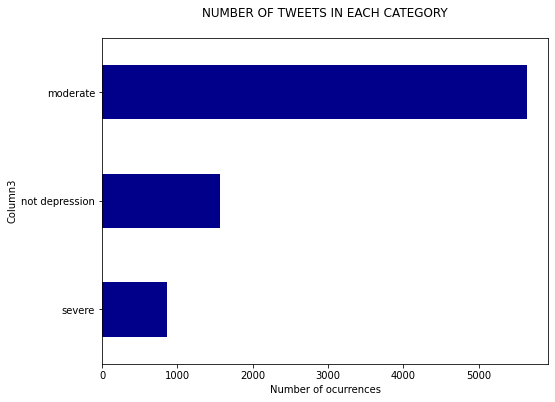

In [2]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue','darkblue']
dataset.groupby('Column3').Column2.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

# PreProcessing

In [2]:
!pip install tweet-preprocessor
import preprocessor as p

def preprocess_tweets(text):
  return p.clean(text)

print(preprocess_tweets(train_x[0]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Waiting for my mind to have a breakdown once the New Year feeling isnt there anymore : I dont know about anyone else, but Im a little bit worried that Ill go back to being depressed in a few days time or something. Last year, I tried not to have any breakdowns for the start of . A mere days later, I broke down crying. I wasnt the same for that entire year. Up until December, where I was ok that month. Now I just wait... its a weird way to act and feel, but it feels a bit normal.


In [4]:
# cleaning the text : deleting the emojis, the existing emails, the punctuation, the present digits,
# the hyperlinks and the stopwords (a,the,is, etc)

def delete_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)  # no emoji


def delete_digits(text):
    text = text.lower()
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    clean = text.translate(str.maketrans('', '', punctuation + '’“”'))
    return clean


stop = set(stopwords.words('english'))
stop.add('gtpoplt')
stop.add('new')
stop.add('year')
stop.add('eve')
stop.add('years')
stop.add('ti')
stop.add('ame')
stop.add('folks')
punct = list(string.punctuation)
stop.update(punct)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def remove_hyperlinks(text):
    for word in text:
        if re.match(r'^http', word):
            text.remove(word)
    return " ".join(text)

def remove_emails(text):
    text = text.split()
    for i in text:
        if '@' in i.strip().lower():
            text.remove(i)
    return " ".join(text)

contraction_dict = {"youre":"you are","im": "i am","wouldnt": "would not","itll": "it will","wasnt": "was not","dont": "do not","ill": "i will","isnt": "is not","cant": "cannot","arent": "are not","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# def denoise_text(text):
#     text = replace_contractions(text)
#     text = remove_words(text)
#     text = remove_emails(text)
#     text = delete_punctuation(text)
#     text = delete_emoji(text)
#     text = delete_digits(text)
#     text = remove_stopwords(text)
#     text = text.split()
#     text = remove_hyperlinks(text)
#     return text



train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]

for i in range(len(train_x)):
  train_x[i] = replace_contractions(train_x[i])
  train_x[i] = remove_emails(train_x[i])
  train_x[i] = delete_punctuation(train_x[i])
  train_x[i] = delete_emoji(train_x[i])
  train_x[i] = delete_digits(train_x[i])
  train_x[i] = remove_stopwords(train_x[i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying 

In [31]:
print(train_x[0])

waiting mind breakdown feeling anymore know anyone else little bit worried go back depressed days something last tried breakdowns start mere days later broke crying entire december ok month wait weird way act feel feels bit normal


# Lemmatization

In [5]:
# lemmatization : crying -> cry, days -> day

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemm(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word, get_pos(word)) for word in text]
    return " ".join(sar_list_lemmatizer)

train_x = train_x.apply(lemm)
test_x = test_x.apply(lemm)

In [33]:
print(train_x[0])

wait mind breakdown feel anymore know anyone else little bit worried go back depressed day something last try breakdown start mere day later broke cry entire december ok month wait weird way act feel feel bit normal


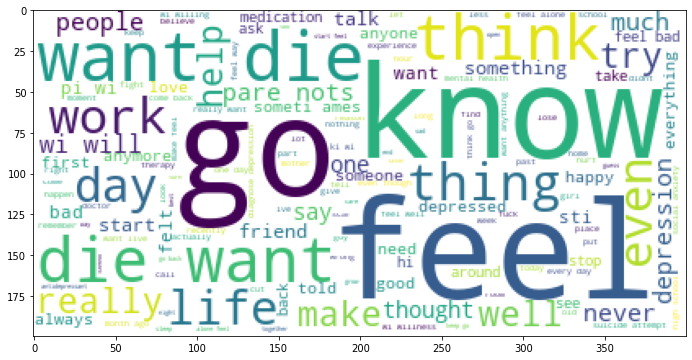

In [ ]:
plt.figure(figsize=(12,6))
text = ' '.join(train_x[dataset['Column3']=='severe'])
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

# Count Vectorizer

In [10]:
# CountVectorizer reprezentation for the user tweets
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(train_x)

x_test_cv = vectorizer.transform(test_x)
print(x_train_cv.shape)

(8068, 10252)


# Data imbalance handling

In [11]:
sm = SMOTE(random_state = 42)
res_x, res_y = sm.fit_resample(x_train_cv, train_y)
print("After OverSampling, counts of label '2': {}".format(sum(res_y == 2)))

After OverSampling, counts of label '2': 5647


In [ ]:
os = RandomOverSampler()
res_x2, res_y2 = os.fit_resample(x_train_cv, train_y)

# Tf-Idf 

In [12]:
# Tf-idf reprezentation for the tweets
from sklearn.feature_selection import chi2
vectorizer = TfidfVectorizer(max_df = 0.15,min_df = 5, ngram_range=(1,2), stop_words='english')
train_x_tf = vectorizer.fit_transform(train_x)
test_x_tf = vectorizer.transform(test_x)
N = 2
# for Product, category_id in sorted(category_to_id_train.items()):
#     features_chi2 = chi2(train_x_tf, train_y == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Product))
#     print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
res_tfx, res_tfy = sm.fit_resample(train_x_tf, train_y)
print(train_x_tf.shape)
print(res_tfx.shape)

(8068, 33909)
(16941, 33909)


# Naive Bayes

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_x, res_y)
pred_y = naive_bayes_classifier.predict(x_test_cv)

score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

In [14]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_tfx, res_tfy)
# naive_bayes_classifier.fit(train_x_tf, train_y)
pred_y = naive_bayes_classifier.predict(test_x_tf)
score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

Accuracy 0.3048062775870525
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2198
           1       0.51      0.23      0.32      1522
           2       0.13      0.85      0.23       358

    accuracy                           0.30      4078
   macro avg       0.40      0.45      0.30      4078
weighted avg       0.50      0.30      0.33      4078



# AdaBoost

In [16]:
# res_x2, res_y2 = sm.fit_resample(train_x_tf, train_y)
ada = AdaBoostClassifier()

# boost = ada.fit(train_x_tf, train_y)
boost = ada.fit(res_tfx, res_tfy)
pred_y = boost.predict(test_x_tf)
print("AdaBoost Classifier Model Accuracy:", accuracy_score(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

AdaBoost Classifier Model Accuracy: 0.4681216282491417
              precision    recall  f1-score   support

           0       0.61      0.35      0.45      2198
           1       0.46      0.64      0.54      1522
           2       0.23      0.43      0.30       358

    accuracy                           0.47      4078
   macro avg       0.43      0.48      0.43      4078
weighted avg       0.52      0.47      0.47      4078



# Regression

In [26]:
class_weight = {0: 1.,
                1: 3.,
                2: 5.}

model = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight=class_weight)
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3)
model = model.fit(res_x, res_y)
y_pred = model.predict(x_test_cv)
print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


Regression Classifier Model Accuracy: 0.3766552231486023
              precision    recall  f1-score   support

           0       0.63      0.34      0.45      2198
           1       0.49      0.36      0.42      1522
           2       0.13      0.65      0.22       358

    accuracy                           0.38      4078
   macro avg       0.42      0.45      0.36      4078
weighted avg       0.54      0.38      0.41      4078

[[754 518 926]
 [363 549 610]
 [ 72  53 233]]


In [25]:

class_weight = {0: 1.,
                1: 3.,
                2: 6.}
model = LinearSVC()
model = model.fit(res_x, res_y)
y_pred = model.predict(x_test_cv)
print("Svc Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


Svc Classifier Model Accuracy: 0.34624816086316823
              precision    recall  f1-score   support

           0       0.63      0.26      0.37      2198
           1       0.48      0.39      0.43      1522
           2       0.13      0.70      0.22       358

    accuracy                           0.35      4078
   macro avg       0.41      0.45      0.34      4078
weighted avg       0.53      0.35      0.38      4078

[[ 567  595 1036]
 [ 293  594  635]
 [  46   61  251]]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [23]:

class_weight = {0: 1.,
                1: 5.,
                2: 10.}
model = RandomForestClassifier(class_weight=class_weight)
model = model.fit(train_x_tf,train_y)
y_pred = model.predict(test_x_tf)
print("RandomForest Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)

RandomForest Classifier Model Accuracy: 0.58582638548308
              precision    recall  f1-score   support

           0       0.58      0.87      0.70      2198
           1       0.62      0.27      0.38      1522
           2       0.46      0.17      0.25       358

    accuracy                           0.59      4078
   macro avg       0.55      0.44      0.44      4078
weighted avg       0.59      0.59      0.54      4078

[[1918  229   51]
 [1091  410   21]
 [ 276   21   61]]


# Word2Vec

In [ ]:
# Word2Vec reprezentation

corpus_text = 'n'.join(train_x)
# corpus_text = 'n'.join(res_x)
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

model1 = gensim.models.Word2Vec(min_count = 5,size = 300, window = 5, alpha = 0.025)
model1.build_vocab(data)
print(len(model1.wv.vocab))
model1.train(data, total_examples = model1.corpus_count, epochs=30)

print(model1.wv.most_similar(positive=["depression"]))

vocab = list(model1.wv.vocab.keys())

word2vec_dict ={}
for word in vocab:
  word2vec_dict[word] = model1.wv.get_vector(word)

maxi=-1
for i,rev in enumerate(train_x):
  tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
# print(maxi)

tok = Tokenizer()
tok.fit_on_texts(train_x)
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(train_x)

max_len = 1464
embed_dim = 300
pad_rev = pad_sequences(encd_rev, maxlen=max_len, padding='post')

# print(pad_rev.shape)

5934
[('hi', 0.9999046325683594), ('destroyed', 0.9998990297317505), ('go', 0.9998937845230103), ('issue', 0.9998888969421387), ('idea', 0.9998859167098999), ('tattoo', 0.9998845458030701), ('maybe', 0.9998841881752014), ('ammunity', 0.9998821020126343), ('deficiency', 0.9998779296875), ('emotional', 0.9998779296875)]


In [ ]:

embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word2vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector

print(embed_matrix.shape)

(10338, 300)


# F1 metric

In [6]:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Neural Network

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 6.}

Y=keras.utils.to_categorical(train_y)  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.25,random_state=42)
def network():
  model=Sequential()
  model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_len,embeddings_initializer=Constant(embed_matrix)))
  model.add(Flatten())
  model.add(Dense(16,activation='relu'))
  model.add(Dropout(0.20))
  # model.add(Dense(16,activation='relu'))
  # model.add(Dropout(0.20))
  model.add(Dense(3,activation='softmax'))

  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
  loss=f1_loss,metrics=[f1])
  return model

model = network()

model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test,y_test), class_weight=class_weight)


In [ ]:
model.summary()

In [ ]:
pred_y = model.predict(x_test)
pred_y = np.argmax(pred_y, axis=1)
y_test=np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test, pred_y))

conf_mat = confusion_matrix(y_test, pred_y)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1398
           1       0.52      0.52      0.52       397
           2       0.80      0.21      0.33       222

    accuracy                           0.74      2017
   macro avg       0.70      0.54      0.56      2017
weighted avg       0.74      0.74      0.72      2017

[[1228  163    7]
 [ 184  208    5]
 [ 146   29   47]]


# BERT

In [7]:
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

label = preprocessing.LabelEncoder()
y = label.fit_transform(train_y)
train_y = to_categorical(y)


m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [8]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install bert-tensorflow==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.1 MB/s 


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 53.0 MB/s 
     |████████████████████████████████| 596 kB 72.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import RobertaTokenizer
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")


In [11]:
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained('google/electra-base-generator')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [13]:
from transformers import TFBertModel, BertModel
bert_base = TFBertModel.from_pretrained('bert-base-uncased')

#select BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'], color = '#171820')
    ax[0].plot(history.history['val_accuracy'], color = '#fdc029')

    ax[1].plot(history.history['loss'], color='#171820')
    ax[1].plot(history.history['val_loss'], color = '#fdc029')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Learning Curves", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [14]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = TOKENIZER.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [23]:
BATCH_SIZE = 16

EPOCHS = 10

CLEAN_TWEETS = False

TRAIN_BASE = True
def build_model(model_layer, learning_rate):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int64')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int64')

    transformer_layer = model_layer([input_ids,attention_masks])

    output = transformer_layer[1]

    output = tf.keras.layers.Dense(64,activation='relu')(output)

    output = tf.keras.layers.Dropout(0.20)(output)

    output = tf.keras.layers.Dense(3,activation='softmax')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    for layer in model.layers[:3]:
       layer.trainable = False 

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=[f1])
    
    return model

In [16]:
if TRAIN_BASE:

    train_input_ids,train_attention_masks = bert_encode(train_x,60)
    test_input_ids,test_attention_masks = bert_encode(test_x,60)

    print('Train length:', len(train_input_ids))
    print('Test length:', len(test_input_ids))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train length: 8068
Test length: 4078


In [21]:
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [24]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
if TRAIN_BASE:
  history = BERT_base.fit([train_input_ids,train_attention_masks], train_y, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)  

plot_learning_curves(history)

Epoch 1/10
404/404 [==============================] - 171s 424ms/step - loss: 0.6626 - f1: 0.3244 - val_loss: 0.9437 - val_f1: 0.0150
Epoch 2/10
404/404 [==============================] - 166s 412ms/step - loss: 0.6616 - f1: 0.3252 - val_loss: 0.9478 - val_f1: 0.0142
Epoch 3/10
145/404 [=========>....................] - ETA: 1:38 - loss: 0.6599 - f1: 0.3260

KeyboardInterrupt: ignored

In [ ]:
pred_y = BERT_base.predict([test_input_ids, test_attention_masks])

if TRAIN_BASE:
    submission_base = pd.DataFrame()
    submission_base['prob'] = pred_y
    submission_base['target'] = np.round(submission_base['prob']).astype(int)
    submission_base.head(10)


In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [30]:
from keras.initializers import GlorotNormal
from keras.callbacks import EarlyStopping

In [71]:
def sentence(texts):
  model = SentenceTransformer("all-mpnet-base-v2")
  embeddings = model.encode(texts)

  return embeddings

In [70]:
def rn(embeddings, train_y):
  input_size = len(embeddings[0])
  model = Sequential()
  initializer = GlorotNormal()

  model.add(Dense(96, input_shape=(input_size,), activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation="softmax", kernel_initializer=initializer))

  model.compile(loss=f1_loss, metrics=[f1], optimizer="adam")

  model.summary()
  return model

In [72]:
def bert_sent_transf_train(model, y_train, X_train):
  dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
  #y_train = tf.one_hot(y_train, depth=2).numpy()
  
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)
  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))
  #y_valid = tf.one_hot(y_valid, depth=2).numpy()
  #print(y_valid)
  early_stopping = EarlyStopping(
      min_delta=0.001, # minimium amount of change to count as an improvement
      patience=10, # how many epochs to wait before stopping
      restore_best_weights=True,
  )
  ## train
  # training = model.fit(x=X_train, y=y_train, batch_size=32, 
  #                     epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
  #                     validation_data=(X_valid, y_valid))
  #train with weights
  class_weight={
      0:1.,
      1:3.,
      2:6,
  }
  training = model.fit(x=X_train, y=y_train, batch_size=32, 
                      epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
                      validation_data=(X_valid, y_valid))
  ## plot loss and accuracy
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return model, dic_y_mapping

def bert_sent_transf_test(model, X_test, dic_y_mapping, y_test):
  predicted_prob = model.predict(X_test)
  predicted = np.argmax(predicted_prob,axis=1) 
  accuracy = metrics.accuracy_score(y_test, predicted)
  print("Accuracy:",  round(accuracy,2))
  print(metrics.classification_report(y_test, predicted))

In [73]:
embeddings = sentence(train_x)

In [74]:
bert_model = rn(embeddings, train_y)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 96)                73824     
                                                                 
 dropout_115 (Dropout)       (None, 96)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 291       
                                                                 
Total params: 74,115
Trainable params: 74,115
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
190/190 [==============================] - 6s 29ms/step - loss: 0.6026 - f1: 0.3635 - val_loss: 0.5015 - val_f1: 0.5623
Epoch 2/30
190/190 [==============================] - 5s 29ms/step - loss: 0.4888 - f1: 0.5433 - val_loss: 0.4403 - val_f1: 0.5900
Epoch 3/30
190/190 [==============================] - 6s 30ms/step - loss: 0.4345 - f1: 0.6011 - val_loss: 0.4082 - val_f1: 0.6224
Epoch 4/30
190/190 [==============================] - 6s 29ms/step - loss: 0.4072 - f1: 0.6239 - val_loss: 0.3910 - val_f1: 0.6335
Epoch 5/30
190/190 [==============================] - 6s 29ms/step - loss: 0.3812 - f1: 0.6464 - val_loss: 0.3694 - val_f1: 0.6652
Epoch 6/30
190/190 [==============================] - 6s 31ms/step - loss: 0.3622 - f1: 0.6656 - val_loss: 0.3581 - val_f1: 0.6674
Epoch 7/30
190/190 [==============================] - 6s 32ms/step - loss: 0.3553 - f1: 0.6691 - val_loss: 0.3485 - val_f1: 0.6620
Epoch 8/30
190/190 [==============================] - 6s 31ms/step - loss: 0.3388 -

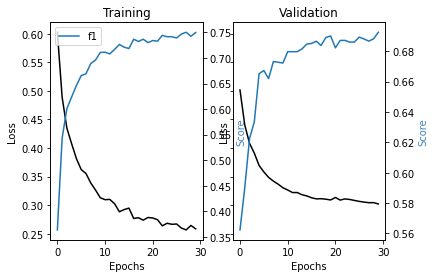

In [75]:
trained_bert, dicmapping = bert_sent_transf_train(bert_model,train_y, embeddings)

In [47]:
embeddings2 = sentence(test_x)

In [ ]:
bert_sent_transf_test(trained_bert, embeddings2, dicmapping, test_y)